In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import logging
import os
import re

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from shapely.geometry import Point
from sklearn.model_selection import train_test_split

import groundwater_utils as g_utils

<IPython.core.display.Javascript object>

In [3]:
logging.getLogger().setLevel(logging.INFO)

<IPython.core.display.Javascript object>

Information on the dataset used, [Ground Water Quality](https://www.kaggle.com/datasets/sivapriyagarladinne/telangana-post-monsoon-ground-water-quality-data?select=ground_water_quality_2018_post.csv)

The goal of this analysis is to get a better sense of the groundwater dataset, and generate a classification model that can predict a binary outcome, is the water hazardous? This variable is a binned version of the 9 different classifications. 

# Relevant context for this analysis:

Definitions of water quality variables:
-------------------------------------------

1. T.H - Total Hardness, the sum of the Ca and Mg concentrations.
2. RSC meq/L - Residual Sodium Carbonate Index, Calcuated using HCO3, CO3, Mg, Ca.
3. SAR - Sodium Adsorption Ratio, Relative amount of Na ions to the combined amount of Ca and Mg.
4. E.C - Electrical Conductivity - measures the number of dissolved salts.
5. TDS - Total Dissolved Solutes, measure of total dissolved solutes, can be estimated from EC.

There are 9 classes of water quality:
------------------------------------------
1. C1S1: Low salinity and low sodium waters are good for irrigation and can be used with most crops with no restriction on use on most of the soils.

2. C2S1: Medium salinity and low sodium waters are good for irrigation and can be used on all most all soils with little danger of development of harmful levels of exchangeable sodium if a moderate amount of leaching occurs. Crops can be grown without any special consideration for salinity control.

3. C3S1: The high salinity and low sodium waters require good drainage. Crops with good salt tolerance should be selected.

4. C3S2: The high salinity and medium sodium waters require good drainage and can be used on coarse - textured or organic soils having good permeability.

5. C3S3: These high salinity and high sodium waters require special soil management, good drainage, high leaching and organic matter additions. Gypsum amendments make feasible the use of these waters.

6. C4S1: Very high salinity and low sodium waters are not suitable for irrigation unless the soil must be permeable and drainage must be adequate. Irrigation waters must be applied in excess to provide considerable leaching. Salt tolerant crops must be selected.

7. C4S2: Very high salinity and medium sodium waters are not suitable for irrigation on fine textured soils and low leaching conditions and can be used for irrigation on coarse textured or organic soils having good permeability.

8. C4S3: Very high salinity and high sodium waters produce harmful levels of exchangeable sodium in most soils and will require special soil management, good drainage, high leaching, and organic matter additions. The Gypsum amendment makes feasible the use of these waters.

9. C4S4: Very high salinity and very high sodium waters are generally unsuitable for irrigation purposes. These are sodium chloride types of water and can cause sodium hazards. It can be used on coarse-textured soils with very good drainage for very high salt tolerant crops. Gypsum amendments make feasible the use of these waters.



[Link to tables referenced for this analysis](http://eagri.org/eagri50/SSAC122/lec27.pdf)

In [4]:
# normally I'd use a globals file but this is the only global so just going to keep it up here at the top.
COLUMN_RENAME_DICT = {
    "F -": "F",
    "Cl -": " Cl",
    "SO4-2": "SO4",
    "Ca+2": "Ca",
    "Mg+2": "Mg",
    "K+": "K",
    "Na+": "Na",
    "EC": "E.C",
    "NO3- ": "NO3",
    "NO3 ": "NO3",
    "RSC  meq  / L": "RSC meq/L",
}

<IPython.core.display.Javascript object>

In [5]:
# read in state and district shapefile and do some minimal cleaning up of variables.
state_and_district_gdf = (
    gpd.read_file("/groundwater_analysis/DISTRICT_BOUNDARY.shp")
    .assign(
        state=lambda x: x["STATE"].str.replace(">", "A"),
        district=lambda x: x["District"].str.replace(">", "A"),
    )  # need to correct the projection because the one in this shapefile is crazy
    .to_crs(epsg=4326)
)

ERROR 1: PROJ: proj_create_from_database: Open of /usr/local/anaconda/envs/py3/share/proj failed


<IPython.core.display.Javascript object>

In [6]:
# read in the 3 years of ground water quality data
# perform some essential clean up // normalization of column values
# reason for this is that there are differences across years - different columns and names for the same col
all_gw_df_list = []
for year in ["2018", "2019", "2020"]:
    all_gw_df_list.append(
        pd.read_csv(f"/groundwater_analysis/ground_water_quality_{year}_post.csv")
        .rename(columns=COLUMN_RENAME_DICT)
        .assign(year=year)
    )

all_ground_water_quality_df = pd.concat(all_gw_df_list)
all_ground_water_quality_df.columns = all_ground_water_quality_df.columns.str.replace(
    " ", ""
)

all_ground_water_quality_df = (
    (
        all_ground_water_quality_df.drop(
            columns=["CO_-2", "HCO_-", "Cl", "Unnamed:8"]
        ).assign(
            village=lambda x: x["village"].str.lower(),
            geometry=lambda x: [Point(xy) for xy in zip(x["long_gis"], x["lat_gis"])],
            # water quality classification is something like "C2S3"
            # referring to salinity and sodicity
            # splitting these up to increase group size
            salinity_hazard=lambda x: x["Classification"].str.split("S").str[0],
            sodicity_hazard=lambda x: "S" + x["Classification"].str.split("S").str[1],
            is_water_hazardous=lambda x: np.where(
                x["Classification"].isin(["C1S1", "C2S1"]), False, True
            ),
        )
    )
    .query(
        "Classification not in ['O.G', 'OG']"
    )  # idk what this classification is, so we're removing it.
    .drop_duplicates()
)

ground_water_quality_gdf = gpd.GeoDataFrame(
    all_ground_water_quality_df, geometry=all_ground_water_quality_df["geometry"]
)
ground_water_quality_gdf = ground_water_quality_gdf.set_crs(epsg=4326)

ground_water_quality_gdf.columns = ground_water_quality_gdf.columns.str.replace(" ", "")

<IPython.core.display.Javascript object>

## EDA

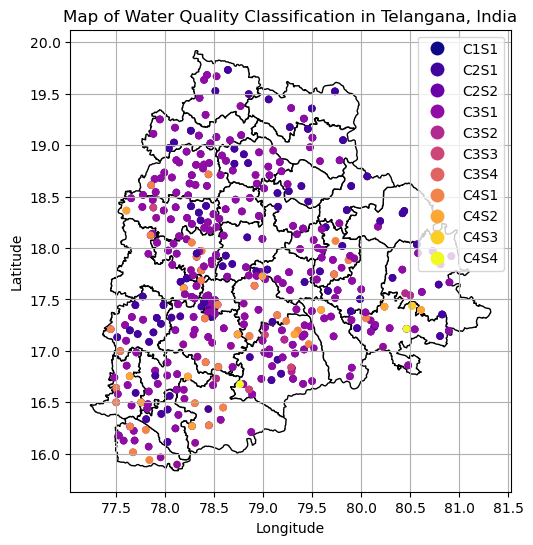

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
state_and_district_gdf.query("state == 'TELANGANA'").plot(
    facecolor="white", edgecolor="k", ax=ax
)

ground_water_quality_gdf.plot(
    ax=ax, column="Classification", legend=True, cmap="plasma", markersize=20
)

plt.title("Map of Water Quality Classification in Telangana, India")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

Geolocations of the 9 water quality classifications across the state of Telangana, India. Generally there are not any super recognizable spatial patterns. However We see mostly darker purple colors indicating lower salinity and lower sodicity. 

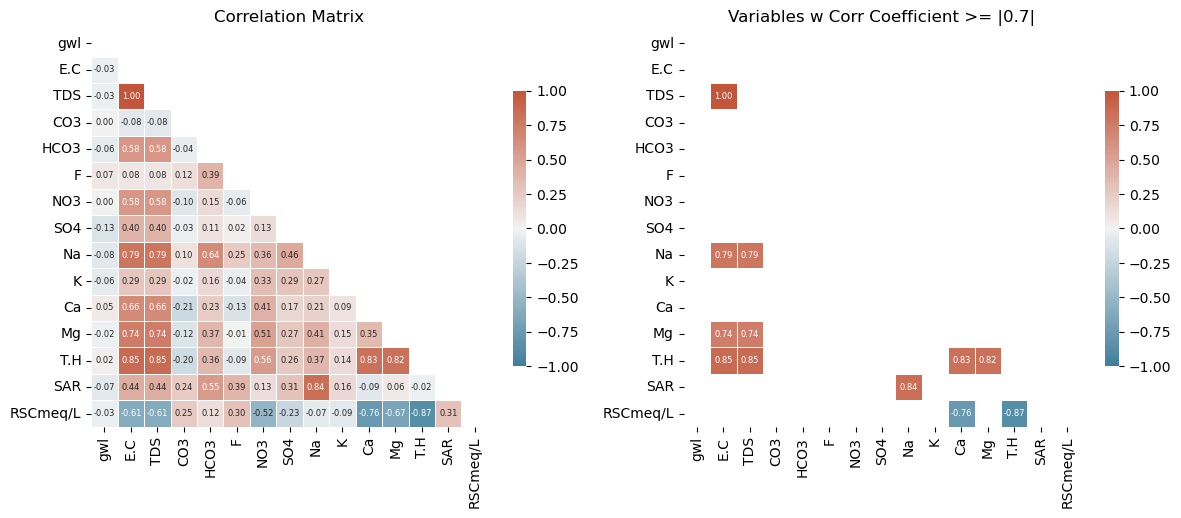

<IPython.core.display.Javascript object>

In [8]:
correlation_matrix = ground_water_quality_gdf.drop(
    columns=["sno", "lat_gis", "long_gis", "is_water_hazardous"]
).corr(numeric_only=True)

# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(12, 6))

# lets create a mask to reduce redundancy
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a mask to highlight cells with a correlation coefficient exceeding a threshold
threshold = 0.7
highlight_mask = np.abs(correlation_matrix) >= threshold

# Combine the two masks
combined_mask = mask | ~highlight_mask

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
for mask, ax, title in zip(
    [mask, combined_mask],
    axes.flatten(),
    ["Correlation Matrix", "Variables w Corr Coefficient >= |0.7|"],
):
    # Draw the heatmap with the mask and correct aspect ratio
    hm = sns.heatmap(
        correlation_matrix,
        mask=mask,
        cmap=cmap,
        vmax=1,
        vmin=-1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        annot_kws={"fontsize": 6},
        fmt=".2f",
        ax=ax,
    )
    hm.set_title(title)
plt.tight_layout()
plt.show()

In the above correlation matrix we can see the relationship for all numeric variables, as well as those where the correlation coefficient exceeds a threshold value (absolute value of 0.7), to show the variables that are most highly correlated.

What we see is that `E.C` or Electrical Conductivity, is highly correlated with `Na` and `Mg`, as well as `T.H` (total hardness) As this is a value that measures the number of dissolved  salts, this makes a lot of sense. We notice 100% correlation with `TDS` (total dissolved solutes) which makes sense as this value can be estimated directly from EC. While I was as little surprised that other ions were not more correlated, looking at the left plot shows me that some (`HCO3`, `NO3`, `Ca`) are still moderately correlated, just a bit under the threshold. 

`RSC` is negatively correlated with `Ca` and `T.H`, and though `Mg` is under the 0.7 threshold, if you round up it is, which makes a lot of sense as well as `RSC` is calculated directly from both `Mg` and `Ca`. 

Lastly, `SAR`, the Sodium Adsorption Ratio, is highly correlated with `Na`, which, makes a lot of sense.

In [9]:
highly_correlated_vars = ["E.C", "TDS", "Mg", "Ca", "Na", "RSCmeq/L", "T.H", "SAR"]

<IPython.core.display.Javascript object>

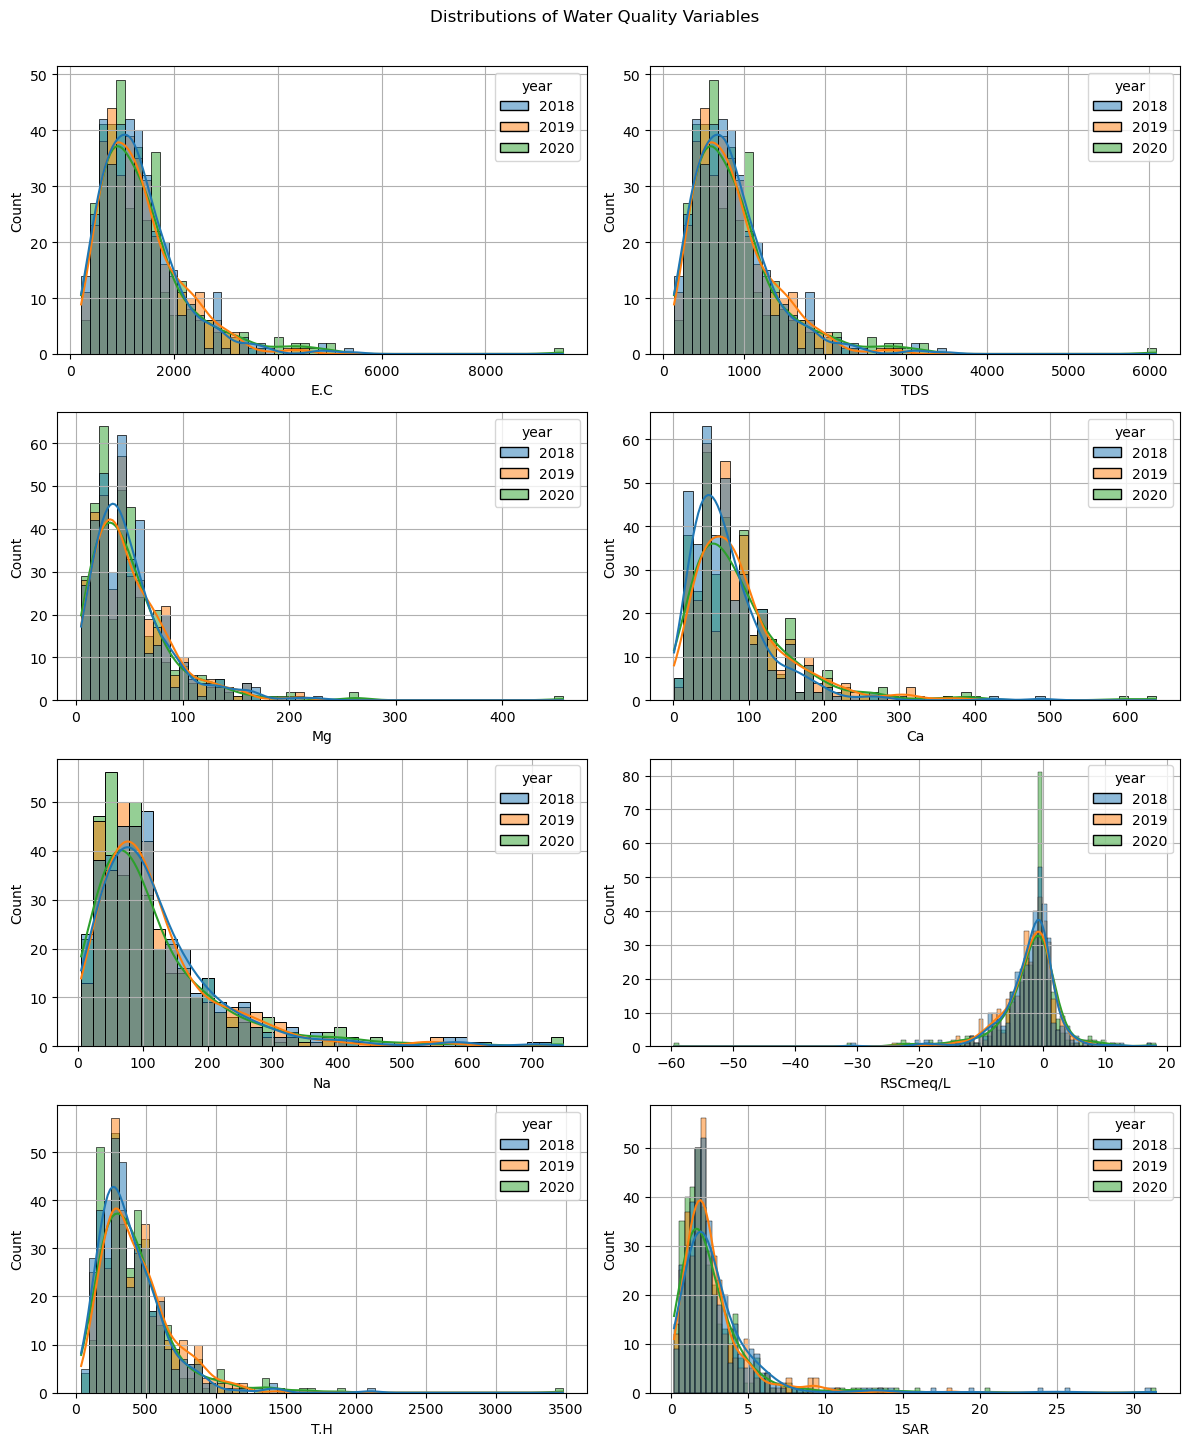

<IPython.core.display.Javascript object>

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(12, 14))

for ax, col in zip(
    axes.flatten(),
    highly_correlated_vars,
):
    b = sns.histplot(data=ground_water_quality_gdf, hue="year", x=col, ax=ax, kde=True)
    b.grid()

plt.tight_layout()
plt.suptitle("Distributions of Water Quality Variables", y=1.03)
plt.show()

In general I see really consistent distributions for the various water qualitiy variables plotted across years. This suggests that there is not much of a temporal influence on these values. 

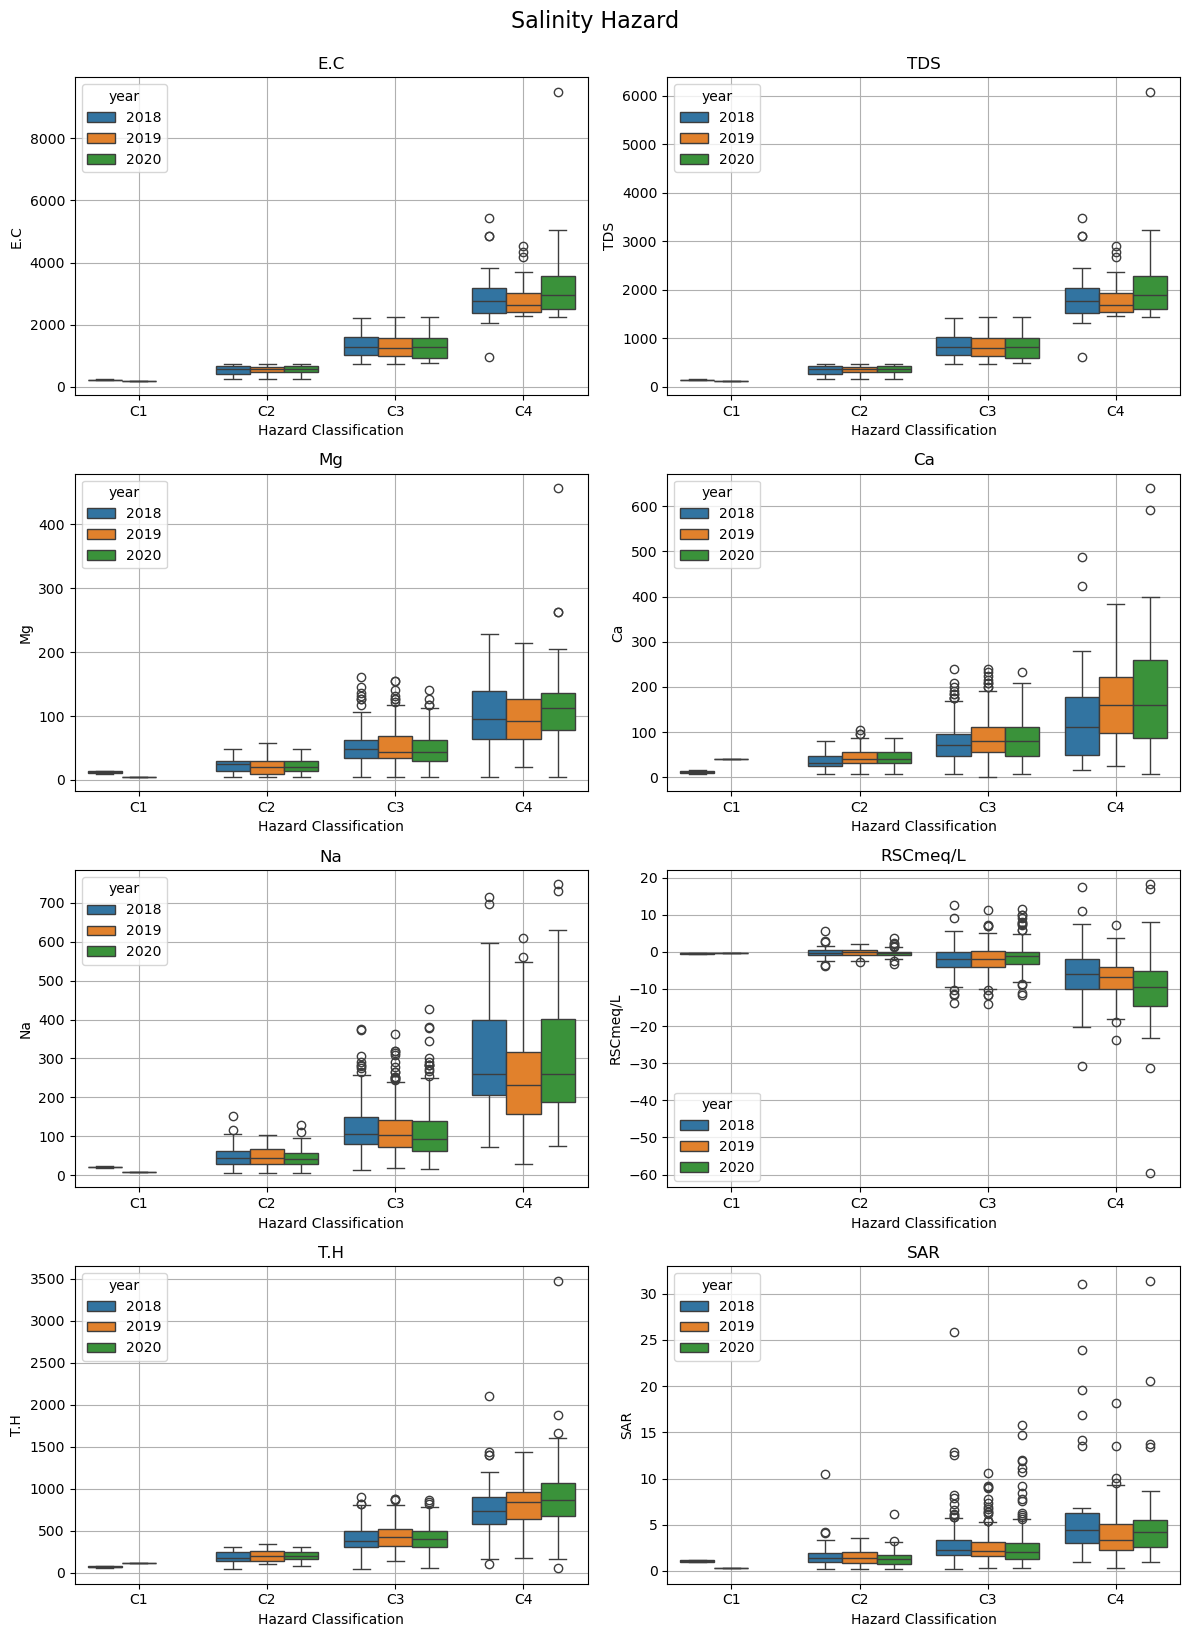

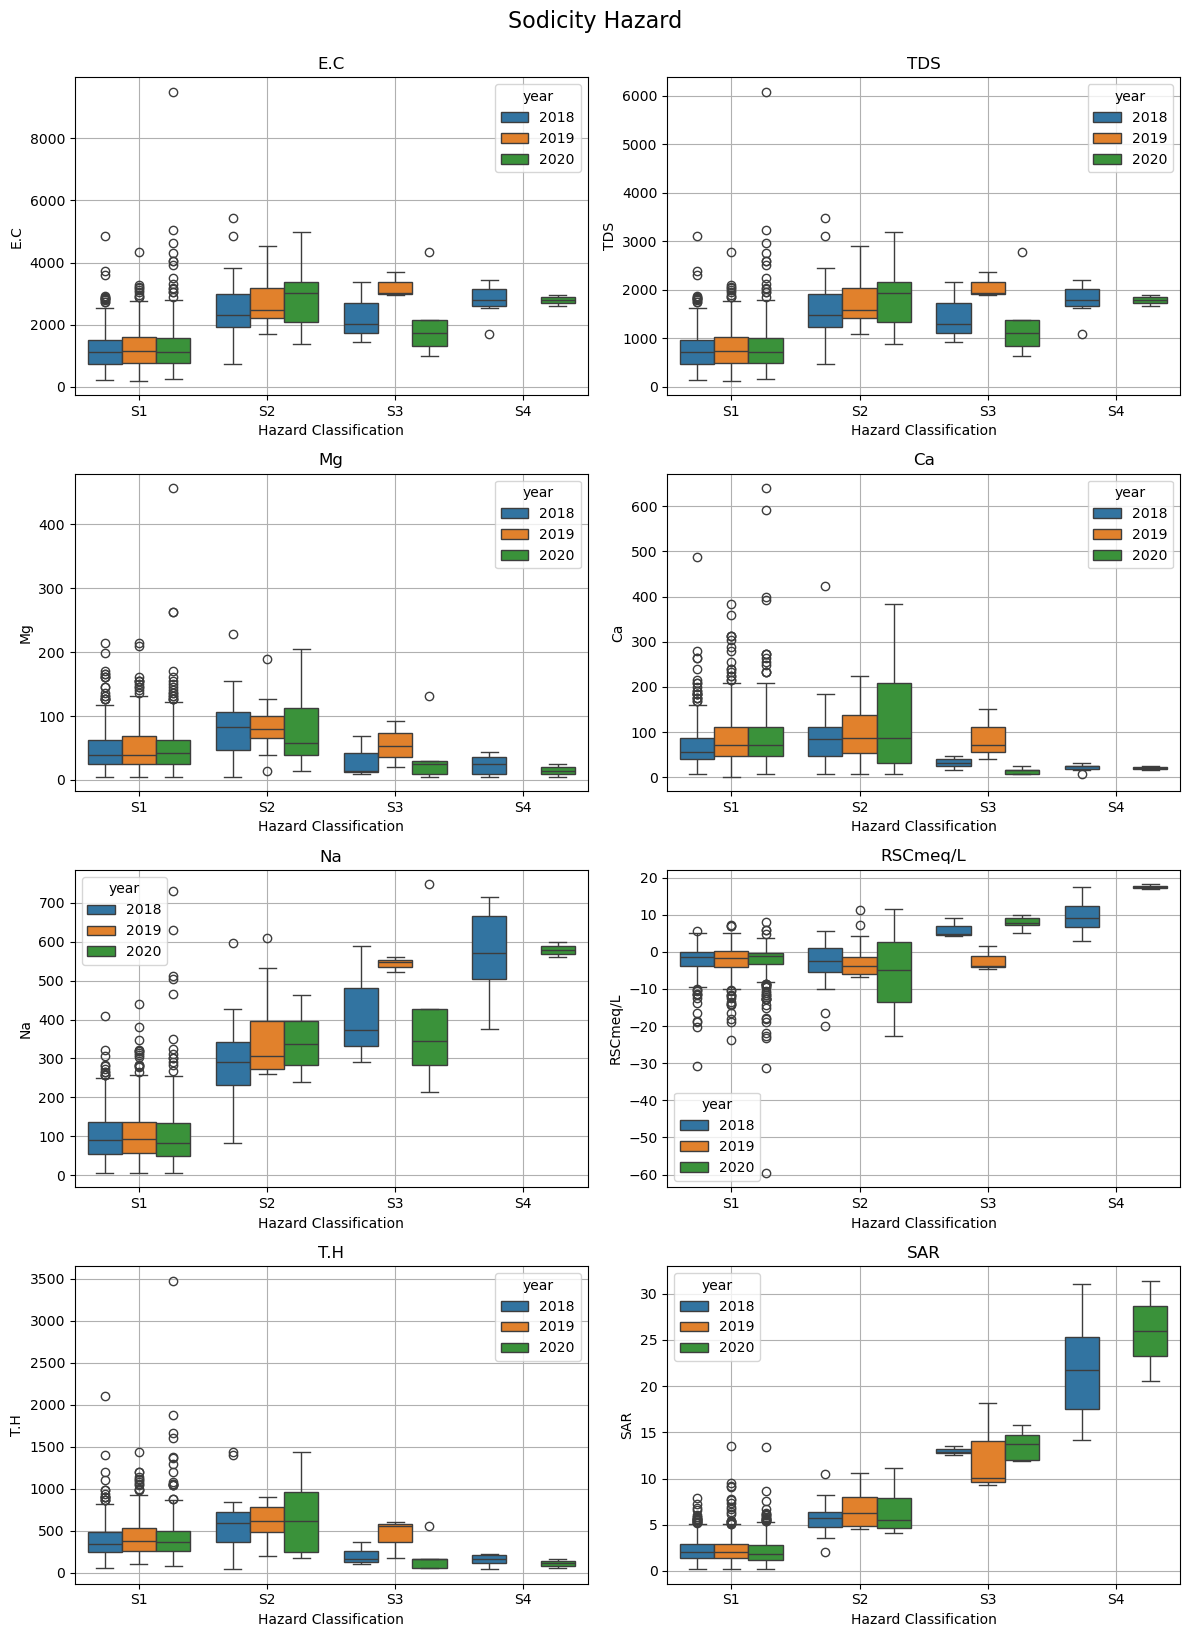

<IPython.core.display.Javascript object>

In [11]:
for hazard in ["salinity_hazard", "sodicity_hazard"]:
    fig, axes = plt.subplots(4, 2, figsize=(12, 16))
    for col, ax in zip(
        highly_correlated_vars,
        axes.flatten(),
    ):
        a = sns.boxplot(
            x=hazard,
            data=ground_water_quality_gdf.sort_values(by=hazard),
            y=col,
            ax=ax,
            hue="year",
        )
        a.set_title(col)
        a.set_xlabel("Hazard Classification")
        a.grid()

    plt.tight_layout()
    plt.suptitle(f"{hazard.replace('_', ' ').title()}", fontsize=16, y=1.02)
    plt.show()

Note that while I prefer violinplots generally, I actually felt like the boxplots showed the outliers a bit better.

**Salinity Hazard**

As the Salinity hazard classification increases, we very consistently see and increase in the free ion values, as well as the E.C, TSD, T.H, and SAR. Where as we see a decrease in RSC meq/L (which is expected). 

**Sodicity Hazard**

When looking at the Sodicity hazard there seems to be a bit more across year variation for E.C and TDS for S3 and S4, which would make sense as there are fewer cases were we see those values.
We see an increase in Na, RSC, and SAR are associated with higher Sodicity hazards, which makes sense as SAR is used to directly classify Sodicity levels, and Na is used in the SAR calculation, as well as the RSC one.
T.H is relatively consistent across Sodicity hazards (though there is some variation, just no clear trend), which indicates it's not a particularly useful variable when predicting Sodicity.

## Modeling

The goal of this analysis is to generate a prediction model to determine if the water is hazardous or not. A binarized variable I created earlier. I have decided to use a Random Forest as tree-based models are relatively robust to imbalanced datasets (we have far more hazardous classifications than not hazardous). 

1. As there is likely a lot of multicollinearity amongst the features, we want to identify those and remove them using Variance Inflation Factors.
2. Do an 80/20 split to get a training and validation set. I am not overly concerned with data leakage, hence why I am not also including a test set.
3. We then want to use a Grid Search with Cross Validation on our training dataset to tune hyperparameters and identify the best ones.
4. Using the best output from this Grid Search, we want to test this model on our training set as well as our validation set. 
5. I also look at the feature importance output from the random forest object to see if we could reduce the number of features further and maintain a high degree of accuracy. 

In [12]:
model_cols = [
    "E.C",  # measures the number of dissolved salts
    "TDS",  # measure of total dissolved solutes, can be estimated from EC
    "F",
    "NO3",
    "SO4",
    "Na",
    "K",
    "Ca",
    "Mg",
    "T.H",  # total hardness, the sum of the Ca and Mg concentrations.
    "SAR",  # relative amount of Na ions to the combined amount of Ca and Mg
    "RSCmeq/L",  # residual sodium carbonate index calculated using HCO3, CO3, Mg, Ca
    "is_water_hazardous",
]

model_df = ground_water_quality_gdf[model_cols].drop_duplicates().dropna()

<IPython.core.display.Javascript object>

In [13]:
feature_df = model_df.drop("is_water_hazardous", axis=1)
predicted_df = model_df["is_water_hazardous"]

<IPython.core.display.Javascript object>

In [14]:
# VIF values that are associated with problematic collinearity are either infinity or > 10
# infinity meaning perfect multicollinearity, and > 10 meaning problematic collinearity.

# calculate initial VIF
vif_data = g_utils.calculate_vif(feature_df=feature_df)

# Iteratively remove features with VIF > 10
while vif_data["VIF"].max() > 10 or float("inf") in vif_data["VIF"].values:

    # Find the feature with the highest VIF
    feature_to_remove = vif_data.sort_values("VIF", ascending=False)["Feature"].iloc[0]
    print(f"Removing feature: {feature_to_remove} with VIF: {vif_data['VIF'].max()}")

    # Drop problematic col from the dataset
    feature_df = feature_df.drop(columns=[feature_to_remove])

    # Recalculate VIFs
    vif_data = g_utils.calculate_vif(feature_df)

# Print final VIFs
print("Final VIFs after removing high VIF features:")
print("-" * 45)
print(vif_data)

Removing feature: E.C with VIF: inf
Removing feature: T.H with VIF: 27745.773411992912
Removing feature: TDS with VIF: 106.21848638779201
Final VIFs after removing high VIF features:
---------------------------------------------
    Feature       VIF
0         F  1.354301
1       NO3  1.859384
2       SO4  1.564526
3        Na  8.385601
4         K  1.273423
5        Ca  3.892741
6        Mg  3.819975
7       SAR  6.838034
8  RSCmeq/L  8.237652


/usr/local/anaconda/envs/py3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


<IPython.core.display.Javascript object>

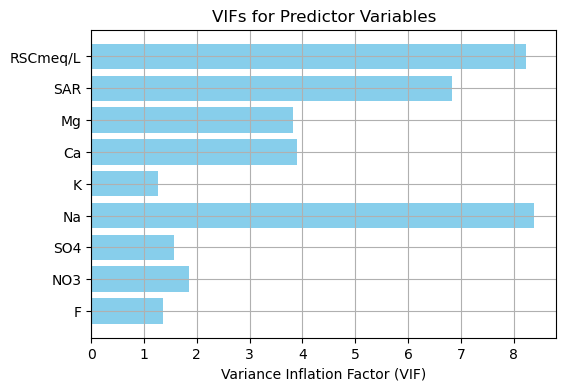

<IPython.core.display.Javascript object>

In [15]:
# Plot VIFs
plt.figure(figsize=(6, 4))
plt.barh(vif_data["Feature"], vif_data["VIF"], color="skyblue")
plt.xlabel("Variance Inflation Factor (VIF)")
plt.grid()
plt.title("VIFs for Predictor Variables")
plt.show()

In [16]:
# update the feature df to include only the features
# selected from the VIF analysis
updated_feature_df = feature_df[vif_data["Feature"].unique().tolist()]

<IPython.core.display.Javascript object>

In [17]:
# next I am going to train test validate.
# specifically, using my train / test sets to do a hyperparameter search to optimize params
# then predict on the validation set
# this will give us a realistic idea as to how our model will perform on completely unseen data

<IPython.core.display.Javascript object>

In [18]:
# Split the data into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    updated_feature_df, predicted_df, test_size=0.2, random_state=42
)

print(f"Train set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Train set size: (876, 9)
Validation set size: (219, 9)


<IPython.core.display.Javascript object>

In [19]:
best_rf = g_utils.hyperparameter_tune_rf(
    feature_training_data=X_train, y_training_data=y_train
)

<IPython.core.display.Javascript object>

In [20]:
g_utils.evaluate_random_forest(
    best_rf=best_rf,
    input_data=X_train,
    y_data=y_train,
    train_or_validation="train",
)

Accuracy on train data with features ['F', 'NO3', 'SO4', 'Na', 'K', 'Ca', 'Mg', 'SAR', 'RSCmeq/L']: 1.0000
Train Classification Report:
------------------------------
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       196
        True       1.00      1.00      1.00       680

    accuracy                           1.00       876
   macro avg       1.00      1.00      1.00       876
weighted avg       1.00      1.00      1.00       876

Train Confusion Matrix:
------------------------------
[[196   0]
 [  0 680]]


<IPython.core.display.Javascript object>

In [21]:
g_utils.evaluate_random_forest(
    best_rf=best_rf,
    input_data=X_val,
    y_data=y_val,
    train_or_validation="validation",
)

Accuracy on validation data with features ['F', 'NO3', 'SO4', 'Na', 'K', 'Ca', 'Mg', 'SAR', 'RSCmeq/L']: 0.9543
Validation Classification Report:
------------------------------
              precision    recall  f1-score   support

       False       0.94      0.87      0.90        54
        True       0.96      0.98      0.97       165

    accuracy                           0.95       219
   macro avg       0.95      0.93      0.94       219
weighted avg       0.95      0.95      0.95       219

Validation Confusion Matrix:
------------------------------
[[ 47   7]
 [  3 162]]


<IPython.core.display.Javascript object>

Admittedly I feel a little weird about 100% accuracy on the training data, and 95% accuracy on the validation data, however, as the features used in this model are so directly related to the classification this might just make sense. 

## Take a look at feature importance

In [22]:
# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame(
    {"feature": updated_feature_df.columns, "importance": best_rf.feature_importances_}
)
feature_importance_df = feature_importance_df.sort_values(
    by="importance", ascending=False
)
feature_importance_df

,feature,importance
3,Na,0.292845
6,Mg,0.202750
5,Ca,0.146666
2,SO4,0.097154
8,RSCmeq/L,0.082738
7,SAR,0.073629
1,NO3,0.050445
0,F,0.038136
4,K,0.015637


<IPython.core.display.Javascript object>

In [23]:
# we see that Na, Mg, Ca are the top 3 most important variables,
# lets see how the model does when we only use those features
# Split the data into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    feature_df[["Na", "Ca", "Mg"]],
    predicted_df,
    test_size=0.2,
    random_state=42,
)

print(f"Train set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Train set size: (876, 3)
Validation set size: (219, 3)


<IPython.core.display.Javascript object>

In [24]:
best_rf = g_utils.hyperparameter_tune_rf(
    feature_training_data=X_train, y_training_data=y_train
)

<IPython.core.display.Javascript object>

In [25]:
g_utils.evaluate_random_forest(
    best_rf=best_rf,
    input_data=X_train,
    y_data=y_train,
    train_or_validation="train",
)

Accuracy on train data with features ['Na', 'Ca', 'Mg']: 0.9886
Train Classification Report:
------------------------------
              precision    recall  f1-score   support

       False       0.98      0.97      0.97       196
        True       0.99      0.99      0.99       680

    accuracy                           0.99       876
   macro avg       0.99      0.98      0.98       876
weighted avg       0.99      0.99      0.99       876

Train Confusion Matrix:
------------------------------
[[190   6]
 [  4 676]]


<IPython.core.display.Javascript object>

In [26]:
g_utils.evaluate_random_forest(
    best_rf=best_rf,
    input_data=X_val,
    y_data=y_val,
    train_or_validation="validation",
)

Accuracy on validation data with features ['Na', 'Ca', 'Mg']: 0.9680
Validation Classification Report:
------------------------------
              precision    recall  f1-score   support

       False       0.98      0.89      0.93        54
        True       0.96      0.99      0.98       165

    accuracy                           0.97       219
   macro avg       0.97      0.94      0.96       219
weighted avg       0.97      0.97      0.97       219

Validation Confusion Matrix:
------------------------------
[[ 48   6]
 [  1 164]]


<IPython.core.display.Javascript object>

When using the random forest feature importance ranking, we see that `Mg`, `Na`, and `Ca` are the most important features, so I decided to run the model on just them. Interestingly, we get an even higher accuracy on the validation set (96%). Lastly, it seems like, `Na` is related to most of the other aggregate metrics, suggesting that it is an important indicator. So lets see how the model does with JUST `Na` as a feature.

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    feature_df[["Na"]],
    predicted_df,
    test_size=0.2,
    random_state=42,
)

print(f"Train set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Train set size: (876, 1)
Validation set size: (219, 1)


<IPython.core.display.Javascript object>

In [28]:
best_rf = g_utils.hyperparameter_tune_rf(
    feature_training_data=X_train, y_training_data=y_train
)

<IPython.core.display.Javascript object>

In [29]:
g_utils.evaluate_random_forest(
    best_rf=best_rf,
    input_data=X_train,
    y_data=y_train,
    train_or_validation="train",
)

Accuracy on train data with features ['Na']: 0.9030
Train Classification Report:
------------------------------
              precision    recall  f1-score   support

       False       0.83      0.71      0.77       196
        True       0.92      0.96      0.94       680

    accuracy                           0.90       876
   macro avg       0.87      0.84      0.85       876
weighted avg       0.90      0.90      0.90       876

Train Confusion Matrix:
------------------------------
[[140  56]
 [ 29 651]]


<IPython.core.display.Javascript object>

In [30]:
g_utils.evaluate_random_forest(
    best_rf=best_rf,
    input_data=X_val,
    y_data=y_val,
    train_or_validation="validation",
)

Accuracy on validation data with features ['Na']: 0.8447
Validation Classification Report:
------------------------------
              precision    recall  f1-score   support

       False       0.74      0.57      0.65        54
        True       0.87      0.93      0.90       165

    accuracy                           0.84       219
   macro avg       0.80      0.75      0.77       219
weighted avg       0.84      0.84      0.84       219

Validation Confusion Matrix:
------------------------------
[[ 31  23]
 [ 11 154]]


<IPython.core.display.Javascript object>

Including just Na as a predictor generated a model with 85% accuracy on completely unseen data, which all-in-all is quite good.